# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»).

**Цель исследования** — построить модель для задачи классификации, которая выберет подходящий тариф.

**Ход исследования**

О качестве данных известно, что, как минимум, не требуется предобработка, однако, все равно проверим повторно. 

Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Анализ.

## Изучение данных

In [1]:
pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 156 kB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 1.8 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import GridSearchCV


from collections import Counter
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import TomekLinks

In [4]:
df = pd.read_csv('/Users/dianatyubeeva/Desktop/datasets/users_behavior.csv')

Откроем файл и изучим документацию:

In [5]:
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Предобработка данных 

Убедимся в отсутствии пропусков и дубликатов:

In [7]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [8]:
df.duplicated().sum() == 0

True

Оценим аномальность параметров:

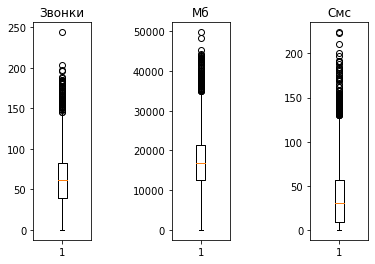

In [9]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 5, 1)
ax_2 = fig.add_subplot(1, 5, 3)
ax_3 = fig.add_subplot(1, 5, 5)

ax_1.boxplot(df['calls']);
ax_1.set_title('Звонки');
ax_2.boxplot(df['mb_used']);
ax_2.set_title('Мб');
ax_3.boxplot(df['messages']);
ax_3.set_title('Смс');

Все "выбросы" более-менее близки к реальности, поэтому ограничивать параметры мы не будем.

Проверим данные на сбалансированность классов (ибо мы решаем задачу классификации):

In [10]:
assert df[df['is_ultra'] == 1].shape[0] / df[df['is_ultra'] == 0].shape[0] != 1, 'Данные сбалансированны по классам'
print('Данные несбалансированны по классам')

Данные несбалансированны по классам


Предполагаемые причины дисбаланса:
* Наличие дубликатов
* Естественные причины (целевая переменная - генотипы и тп.)
* Недостатка размеченных данных

В нашем случая мы имеем стандартную задачу классификации, соответственно, рассмотрим следующую меру по перебалансировки - поиск связи Томека. Он состоит в поиске элементов противоположного класса на близком расстоянии. Это обеспечивает более точную классификацию.

In [11]:
X, y = df.drop(['is_ultra'], axis=1), df['is_ultra'] 
print('Original dataset shape %s' % Counter(y))
ad = TomekLinks(sampling_strategy='majority')
X_res, y_res = ad.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 2229, 1: 985})
Resampled dataset shape Counter({0: 1966, 1: 985})


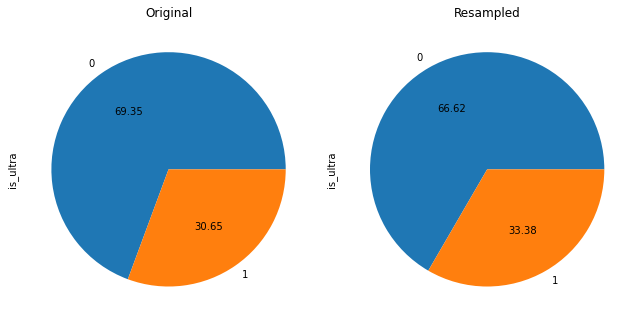

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 5))
autopct = "%.2f"
y.value_counts().plot.pie(autopct=autopct, ax=axs[0])
axs[0].set_title("Original")
y_res.value_counts().plot.pie(autopct=autopct, ax=axs[1])
axs[1].set_title("Resampled")
fig.tight_layout()

Теперь когда данные более сбалансированны и предобработаны можем перейти к обучению моделей. 

## Разделение на выборки

Прежде чем переходить к исследованию, необходимо разделить выборку на валидационную и тренировочную. Однако, перед этим определим признаки и целевую переменную:

`target` - за нее возьмем столбец `ultra` (ибо мы решаем задачи классификации, где подбираем наилучший тариф)

`features` - все кроме столбца `ultra`

In [13]:
features = X_res
target = y_res

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Однако, для подбора гиперпараметров будем использовать GS, поэтому разобьем просто на тестовую и обучающую.

In [14]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42, 
    stratify=target
)

`features_train & target_train` - тренировочная выборка

`features_valid & target_valid` - тестовая выборка

## Исследование моделей 

### Решающие дерево 

#### Accuracy

Сначала оценим долю правильных ответов на валидационной:

In [15]:
#через GridSearchCV() найдем лучшие гиперпараметры для модели
parametrs = {'max_depth': range(1, 10),
             'min_samples_leaf': range(1,8),
             'min_samples_split': range(2,10,2)}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6}

In [16]:
best_result_dt = grid.best_estimator_.score(features_valid, target_valid)
print("Accuracy наилучшей модели на выборке:", best_result_dt)

Accuracy наилучшей модели на выборке: 0.8071065989847716


Изобразим DecisionTreeClassifier() и посмотрим как выглядит модель с найденными гиперпараметрами:

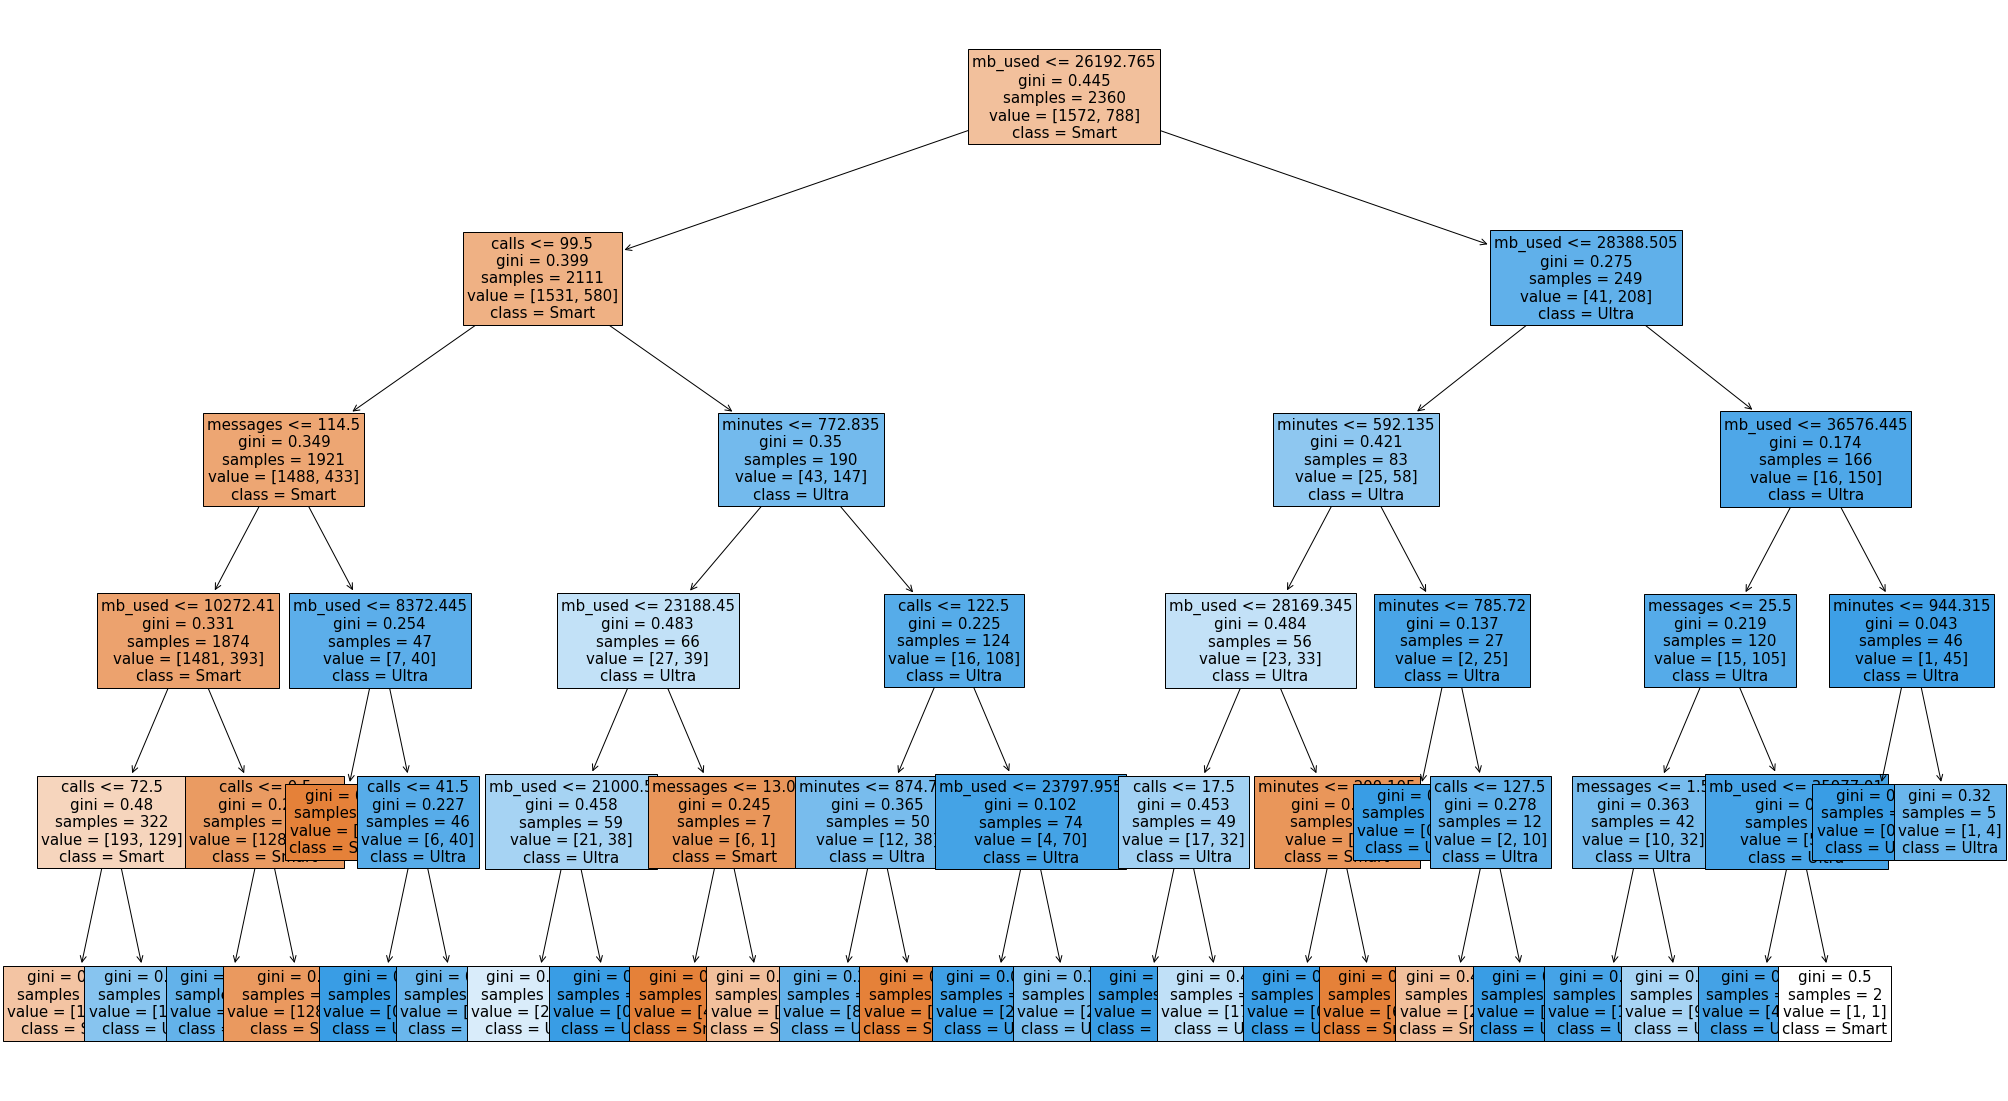

In [17]:
#через модуль tree и plot_tree изобразим DT
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(grid.best_estimator_, 
                   feature_names=features.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   fontsize = 15)

**Наблюдение**: accurancy пвысокое на выборке, больше порога в 0,75. Получается лучшей из моделей типа TreeClassifier будет та, что имеет такие гиперпараметры:

`model = DecisionTreeClassifier(random_state=42, max_depth=5,min_samples_leaf = 1, min_samples_split = 6)`

#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [18]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, grid.best_estimator_.predict(features_valid), labels = [0, 1]).ravel() 

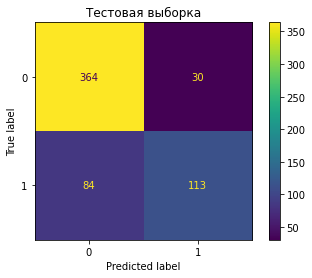

In [19]:
confusion_matrix_2 = confusion_matrix(target_valid, grid.best_estimator_.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Тестовая выборка')
plt.show()

Найдем значения других метрик, связанных с `Confusion matrix` - `recall`, `precision`:

In [20]:
r_v_dt = tp_v / (tp_v + fn_v)
p_v_dt = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v_dt}')
print(f'Precision_valid = {p_v_dt}')

Recall_valid = 0.5736040609137056
Precision_valid = 0.7902097902097902


**Наблюдение**: значение recall говорит о средней доли правильно найденных положительных объектов среди всех объектов положительного класса, целых 57%. precision же говорит о правильных предсказания, чья доля составляет около 80%!

### Случайный лес

#### Accuracy

Сначала оценим долю правильных ответов на валидационной:

In [21]:
%%time
#через GridSearchCV() найдем лучшие гиперпараметры для модели
parametrs = {'n_estimators': range(8,100,30),
             'min_samples_leaf': range(2,5),
             'max_depth': range(1, 10)}

grid = GridSearchCV(RandomForestClassifier(random_state=42), parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

CPU times: user 54.6 s, sys: 362 ms, total: 55 s
Wall time: 55.1 s


{'max_depth': 9, 'min_samples_leaf': 4, 'n_estimators': 68}

In [22]:
best_result_rf = grid.best_estimator_.score(features_valid, target_valid)
print("Accuracy наилучшей модели на выборке:", best_result_rf)

Accuracy наилучшей модели на выборке: 0.8341793570219966


**Наблюдение**: accurancy примерно высокое на выборке, больше 0,75. Получается лучшей из моделей типа RandomForestClassifier будет та, что имеет такие гиперпараметры:

`model = DecisionTreeClassifier(random_state=42, n_estimators=68, min_samples_leaf=4, max_depth=9)`

Более того, accuracy на тестовой выборке показал себя лучше, чем в предыдущей модели. 

#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [23]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, grid.best_estimator_.predict(features_valid), labels = [0, 1]).ravel() 

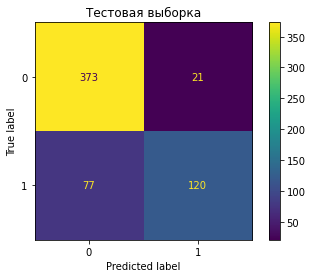

In [24]:
confusion_matrix_2 = confusion_matrix(target_valid, grid.best_estimator_.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Тестовая выборка')
plt.show()

Найдем значения других метрик, связанных с `Confusion matrix` - `recall`, `precision`:

In [25]:
r_v_rf = tp_v / (tp_v + fn_v)
p_v_rf = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v_rf}')
print(f'Precision_valid = {p_v_rf}')

Recall_valid = 0.6091370558375635
Precision_valid = 0.851063829787234


**Наблюдение**: значение recall о средней доли правильно найденных положительных объектов среди всех объектов положительного класса, целых 60%. precision же говорит о правильных предсказания, чья доля составляет около 85%.

Стоит отметить, что у предыдущей модели доля правильных предсказаний была ниже.

### Логическая регрессия

#### Accuracy


In [26]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
p_v = model.predict(features_valid)
a_v = model.score(features_valid, target_valid)
print("Accuracy на валидационной выборке:", a_v)

Accuracy на валидационной выборке: 0.6717428087986463


#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [27]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, model.predict(features_valid), labels = [0, 1]).ravel() 

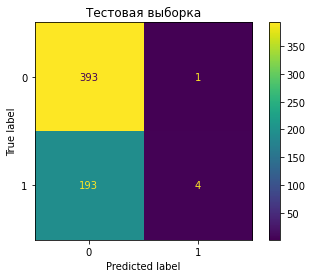

In [28]:
confusion_matrix_2 = confusion_matrix(target_valid, model.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Тестовая выборка')
plt.show()

Найдем значения других метрик, связанных с `Confusion matrix` - `recall`, `precision`:

In [29]:
r_v = tp_v / (tp_v + fn_v)
p_v = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v}')
print(f'Precision_valid = {p_v}')

Recall_valid = 0.02030456852791878
Precision_valid = 0.8


**Наблюдение**: recall очень низок, что говорит о мало найденных правильных объектов. precision же высок, но ниже, чем у предыдущей модели. 

## Выбор модели и доп. исследование на адекватность

### Выбор модели

Соберем все показатели в одну таблицу и выберем модель, которую далее будем проверять:

In [30]:
all_in_one = {
    'model_type' : ['Tree', 'Random Forest', 'Logistic Regression'],
    'accuracy' : [round(best_result_dt,3), round(best_result_rf,3), round(a_v,3)],
    'recall' : [round(r_v_dt, 3), round(r_v_rf, 3) , round(r_v, 3)],
    'precision' : [round(p_v_dt, 3), round(p_v_rf, 3) , round(p_v, 3)]
}
all_in_one = pd.DataFrame(all_in_one)
all_in_one

,model_type,accuracy,recall,precision
0,Tree,0.807,0.574,0.790
1,Random Forest,0.834,0.609,0.851
2,Logistic Regression,0.672,0.020,0.800


Несмотря на медлительность модели, RandomForest явялется лучшей по почти всем показателям. Ее проверим на тест. выборке и дополнительно исследуем. 

#### Roc-curve, Auc

Помимо вышеупомянутых метрик, посчитаем `Auc` и построим кривую `Roc`:

RandomForestClassifier: ROC AUC=0.853


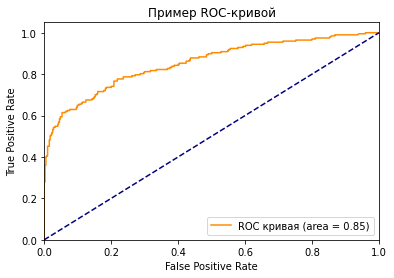

In [31]:
model = RandomForestClassifier(random_state=42, 
                               max_depth = grid.best_params_['max_depth'],
                               min_samples_leaf = grid.best_params_['min_samples_leaf'],
                               n_estimators = grid.best_params_['n_estimators'])
model.fit(features_train, target_train)
# получаем предказания
lr_probs = model.predict_proba(features_valid)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(target_valid, lr_probs)
print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, lr_probs)
roc_auc_rf = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Чем больше площадь под кривой (AUC), тем лучше классификация. В нашем случае `Auc` = 0.853. Оно близко к 1, что говорит о хорошем качестве модели. Другими словами, модель делает в целом правильные предсказания с вероятностью 0,85. 

### Сравнение с константной моделью

#### Accuracy

In [32]:
dc = DummyClassifier(strategy='most_frequent', random_state=412)
dc.fit(features_train, target_train)
a_tr = dc.score(features_valid, target_valid)
print("Accuracy на тестовой выборке:", a_tr)

Accuracy на тестовой выборке: 0.6666666666666666


#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [33]:
tn_t, fp_t, fn_t, tp_t = confusion_matrix(target_valid, dc.predict(features_valid), labels = [0, 1]).ravel()

In [34]:
r_t = tp_t / (tp_t + fn_t)
p_t = tp_t / (tp_t + fp_t)
print(f'Recall_test = {r_t}')
print(f'Precision_test = {p_t}')

Recall_test = 0.0
Precision_test = nan


/var/folders/sq/dt9h5cfs0jq5hdppzy0_9xfr0000gn/T/ipykernel_5089/657516081.py:2: RuntimeWarning: invalid value encountered in long_scalars
  p_t = tp_t / (tp_t + fp_t)


Из-за особенности модели сложно опираться на метрики `recall`, `precision`, поэтому дополнительно оценим `Auc`.

#### Roc-curve, Auc

Помимо вышеупомянутых метрик, посчитаем `Auc` и построим кривую `Roc`:

DummyClassifier: ROC AUC=0.500


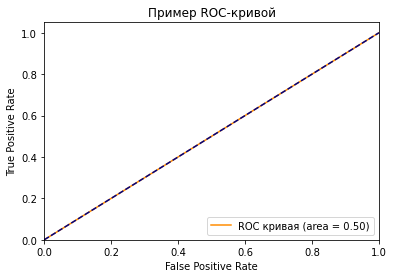

In [35]:
model = dc
model.fit(features_train, target_train)
# получаем предказания
lr_probs = model.predict_proba(features_valid)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(target_valid, lr_probs)
print('DummyClassifier: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, lr_probs)
roc_auc_dc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_dc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Auc = 0.5 это очень плохой показатель для модели, который говорит, что предсказания выбираются правильно лишь в 50%!

#### Финальная таблица

In [36]:
all_in_one = {
    'model_type' : ['Random Forest', 'Dummy'],
    'accuracy_test' : [round(best_result_rf, 3), round(a_tr, 3)],
    'recall_test' : [round(r_v_rf, 3), round(r_v ,3)],
    'precision_test' : [round(p_v_rf, 3), round(p_v ,3)],
    'roc_auc' : [round(roc_auc_rf, 3), round(roc_auc_dc, 3)]
}
all_in_one = pd.DataFrame(all_in_one)
all_in_one

,model_type,accuracy_test,recall_test,precision_test,roc_auc
0,Random Forest,0.834,0.609,0.851,0.853
1,Dummy,0.667,0.020,0.800,0.500


Модель прошла проверку!

## Вывод

Исходя из всех использованных метрик качества, пришли к тому, что RandomForest больше всего подойдет для определения подходящего тарифа, ибо доля правильных ответов у него наибольшее. Однако, он самый медлительный. Остальные модели не подошли не только из-за accurancy, но и точности, полности работы алгоритма. 